## Домашняя работа №6

Ссылка на датасет kaggle - https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation

In [6]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import files
!pip install rarfile
import rarfile

In [7]:
def data_iterator(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask

In [6]:
uploaded = files.upload()
!ls

Saving MRI.rar to MRI.rar
MRI.rar  sample_data


In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
!ls

sample_data


In [8]:
rf = rarfile.RarFile("/content/drive/MyDrive/NN/MRI.rar")
for f in rf.infolist():
    print(f.filename, f.file_size)
    if f.filename == "README":
        print(rf.read(f))
rf.extractall()

Выходные данные были обрезаны до нескольких последних строк (5000).
MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_30.tif 203102
MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_30_mask.tif 65746
MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_31.tif 203102
MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_31_mask.tif 65746
MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_32.tif 203102
MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_32_mask.tif 65746
MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_33.tif 203102
MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_33_mask.tif 65746
MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_34.tif 203102
MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_34_mask.tif 65746
MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_35.tif 203102
MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_35_mask.tif 65746
MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_36.tif 203102
MRI/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_36_mask.tif 65746
MRI/TCGA_DU_7299_19910417/TCGA_DU_72

In [9]:
DataPath = "/content/MRI/"

dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [10]:
len(dirs), len(images), len(masks)

(3929, 3929, 3929)

In [11]:
imInfo_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks})
imInfo_df.head()

,directory,images,masks
0,TCGA_HT_7475_19970918,TCGA_HT_7475_19970918_11.tif,TCGA_HT_7475_19970918_11_mask.tif
1,TCGA_HT_7475_19970918,TCGA_HT_7475_19970918_23.tif,TCGA_HT_7475_19970918_23_mask.tif
2,TCGA_HT_7475_19970918,TCGA_HT_7475_19970918_6.tif,TCGA_HT_7475_19970918_6_mask.tif
3,TCGA_HT_7475_19970918,TCGA_HT_7475_19970918_21.tif,TCGA_HT_7475_19970918_21_mask.tif
4,TCGA_HT_7475_19970918,TCGA_HT_7475_19970918_17.tif,TCGA_HT_7475_19970918_17_mask.tif


Image shape = (256, 256, 3)

In [12]:
def plot_images():
    idx = np.random.randint(0, len(imInfo_df))
    
    imagePath = os.path.join(DataPath, imInfo_df['directory'].iloc[idx], imInfo_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imInfo_df['directory'].iloc[idx], imInfo_df['masks'].iloc[idx])
    
    image = Image.open(imagePath)
    mask = Image.open(maskPath)
    
    fig, axs = plt.subplots(1,3, figsize=[13,15])
    
    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.3)
    axs[2].set_title('MRI with mask')
    
    plt.grid(False)
    plt.show()

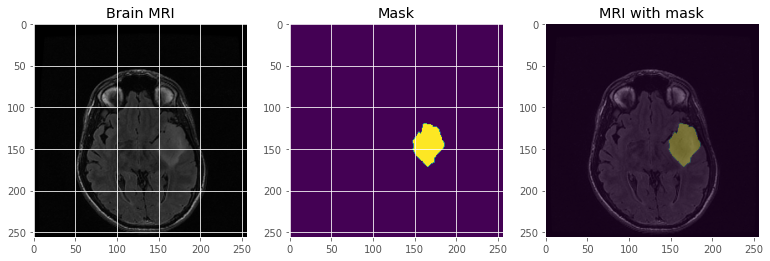

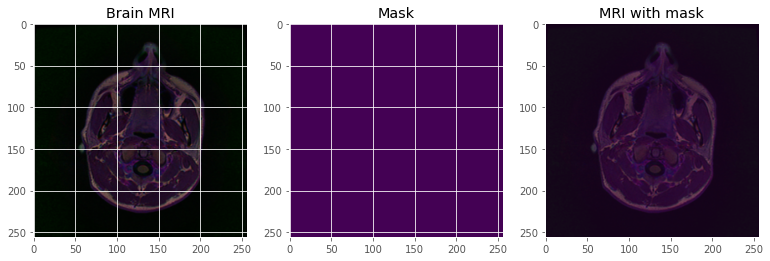

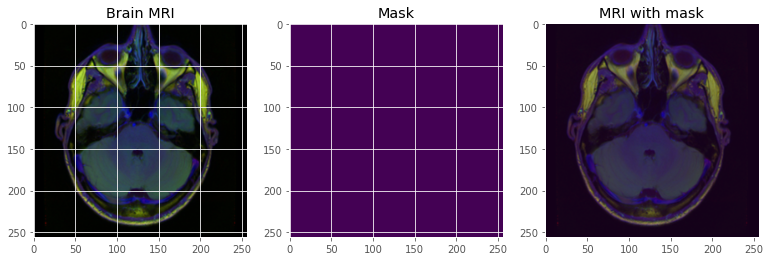

In [13]:
for i in range(3):
    plot_images()

Добавим в наш датафрейм путь к файлам

In [14]:
imInfo_df['image-path'] = DataPath + imInfo_df['directory'] + '/' + imInfo_df['images']
imInfo_df['mask-path'] = DataPath + imInfo_df['directory'] + '/' + imInfo_df['masks'] 

In [15]:
train, test = train_test_split(imInfo_df, test_size=0.25, random_state=21)

In [54]:
EPOCHS = 30
BATCH_SIZE = 64
IMG_HIEGHT = 256
IMG_WIDTH = 256
CHANNELS = 3

Генерируем картинки трейна

In [55]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(IMG_HIEGHT, IMG_WIDTH),
                                            color_mode='rgb')

tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(IMG_HIEGHT, IMG_WIDTH),
                                            color_mode='grayscale')    

Found 2946 validated image filenames.
Found 2946 validated image filenames.


Генерируем картинки валидации, помня, что их нельзя вращать

In [56]:
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)



vimage_generator=imagegen.flow_from_dataframe(dataframe=test,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(IMG_HIEGHT,IMG_WIDTH),
                                            color_mode='rgb')

vmask_generator=maskgen.flow_from_dataframe(dataframe=test,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(IMG_HIEGHT,IMG_WIDTH),
                                            color_mode='grayscale')    

Found 983 validated image filenames.
Found 983 validated image filenames.


Засовываем в итератор

In [57]:
train_gen = data_iterator(timage_generator, tmask_generator)
valid_gen = data_iterator(vimage_generator, vmask_generator)

Построение модели

In [58]:
def Unet(input_shape=(256, 256, 3), n_filters=16, dropout=0.2):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(n_filters, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(n_filters, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(block_1_out)
    x = Dropout(dropout)(x)

    # Block 2
    x = Conv2D(n_filters*2, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(n_filters*2, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(block_2_out)
    x = Dropout(dropout)(x)

    # Block 3
    x = Conv2D(n_filters*4, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(n_filters*4, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(block_3_out)
    x = Dropout(dropout)(x)

    # Block 4
    x = Conv2D(n_filters*8, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(n_filters*8, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(block_4_out)
    x = Dropout(dropout)(x)

    # Block 5
    x = Conv2D(n_filters*16, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(n_filters*16, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    block_5_out = Activation('relu')(x)


    # UP 1
    x = Conv2DTranspose(n_filters*8, (2, 2), strides=(2, 2), padding='same')(x)
    x = concatenate([x, block_4_out])
    x = Dropout(dropout)(x)

    x = Conv2D(n_filters*8, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(n_filters*8, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(n_filters*4, (2, 2), strides=(2, 2), padding='same')(x)
    x = concatenate([x, block_3_out])
    x = Dropout(dropout)(x)
    
    x = Conv2D(n_filters*4, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(n_filters*4, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(n_filters*2, (2, 2), strides=(2, 2), padding='same')(x)
    x = concatenate([x, block_2_out])
    x = Dropout(dropout)(x)
    
    x = Conv2D(n_filters*2, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(n_filters*2, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(x)
    x = concatenate([x, block_1_out])
    x = Dropout(dropout)(x)
    
    x = Conv2D(n_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(n_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 256, 256, 16) 64          block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 256, 256, 16) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

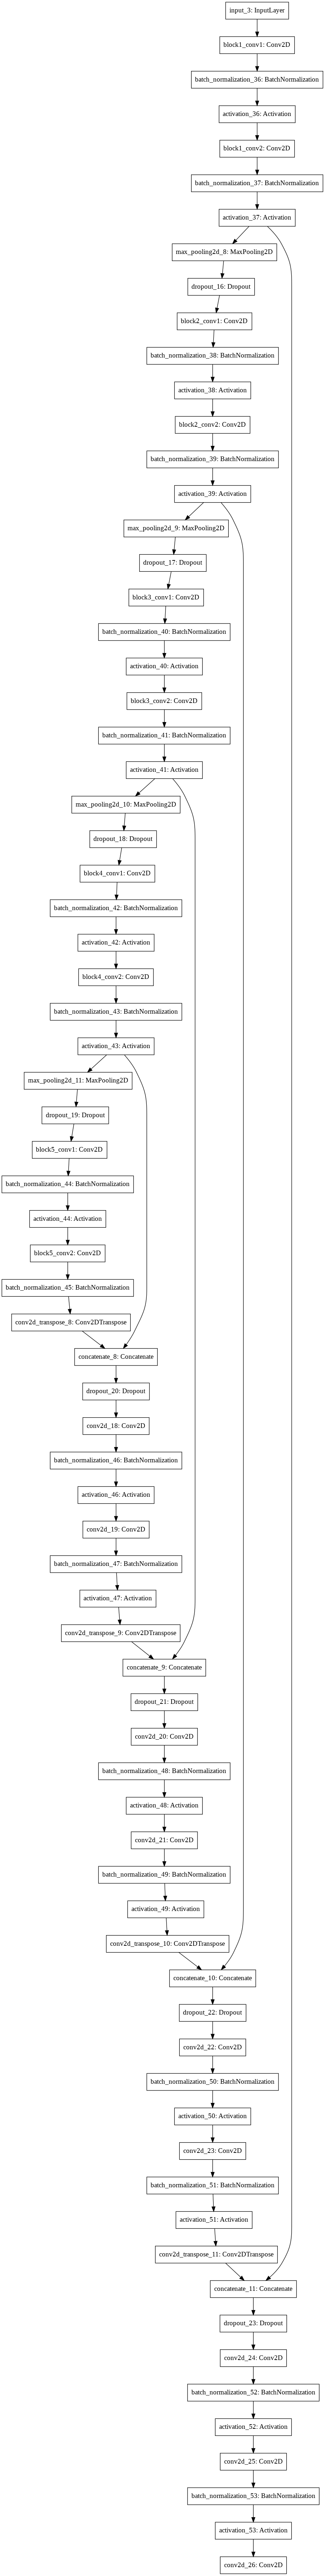

In [59]:
model = Unet()

plot_model(model, to_file='model.png')

In [60]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint('model-brain-mri.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [61]:
STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = vimage_generator.n/BATCH_SIZE

In [62]:
results = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID)

Epoch 1/30
46/46 [==============================] - 66s 1s/step - loss: 0.0697 - accuracy: 0.9912 - val_loss: 0.0718 - val_accuracy: 0.9900

Epoch 00001: val_loss improved from inf to 0.07180, saving model to model-brain-mri.h5
Epoch 2/30
46/46 [==============================] - 66s 1s/step - loss: 0.0579 - accuracy: 0.9922 - val_loss: 0.0603 - val_accuracy: 0.9899

Epoch 00002: val_loss improved from 0.07180 to 0.06033, saving model to model-brain-mri.h5
Epoch 3/30
46/46 [==============================] - 65s 1s/step - loss: 0.0496 - accuracy: 0.9928 - val_loss: 0.0504 - val_accuracy: 0.9916

Epoch 00003: val_loss improved from 0.06033 to 0.05042, saving model to model-brain-mri.h5
Epoch 4/30
46/46 [==============================] - 66s 1s/step - loss: 0.0437 - accuracy: 0.9928 - val_loss: 0.0559 - val_accuracy: 0.9859

Epoch 00004: val_loss did not improve from 0.05042
Epoch 5/30
46/46 [==============================] - 66s 1s/step - loss: 0.0381 - accuracy: 0.9933 - val_loss: 0.0560

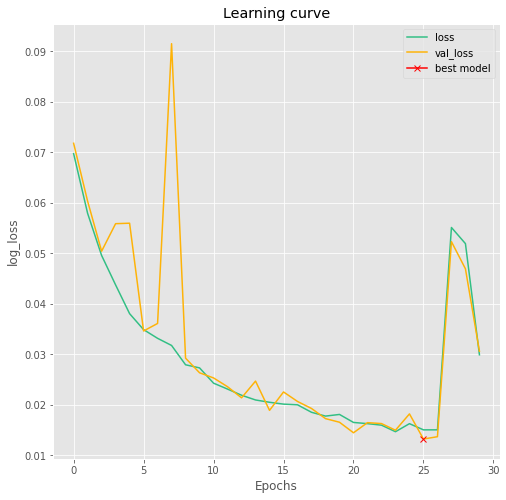

In [63]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
plt.plot(results.history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
# plt.grid(False)
plt.show()

In [64]:
model.load_weights('model-brain-mri.h5')

In [65]:
eval_results = model.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)

15/15 [==============================] - 3s 189ms/step - loss: 0.0129 - accuracy: 0.9963


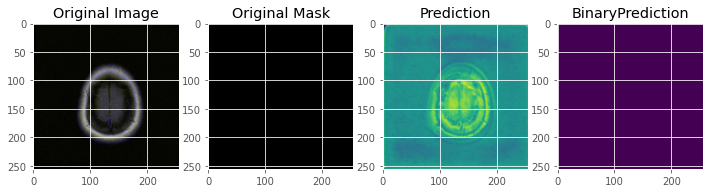

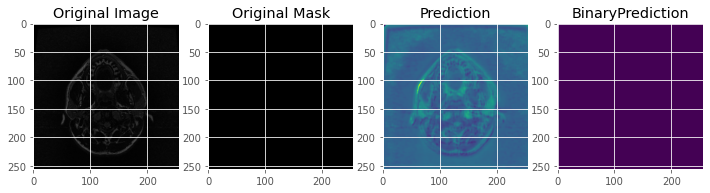

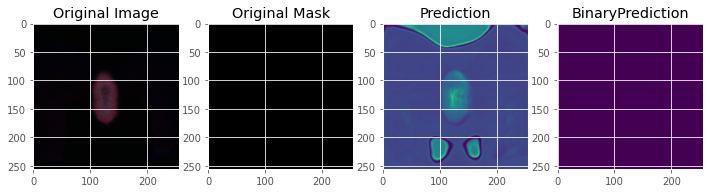

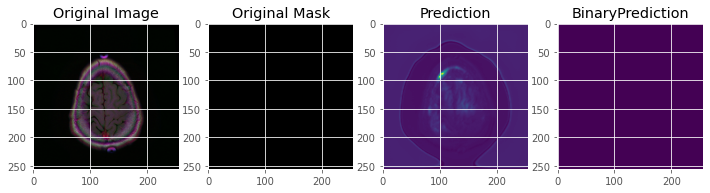

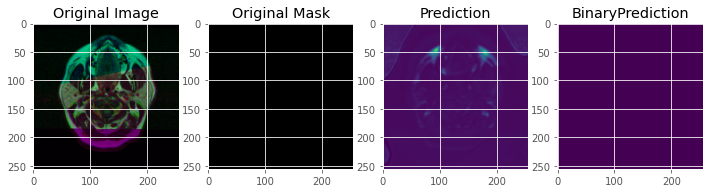

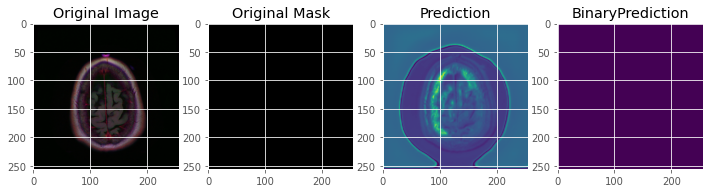

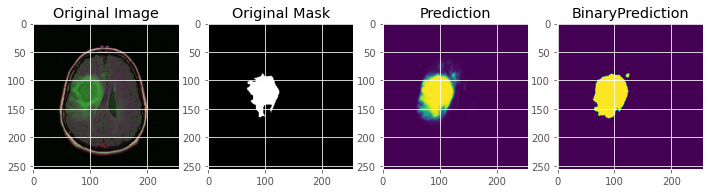

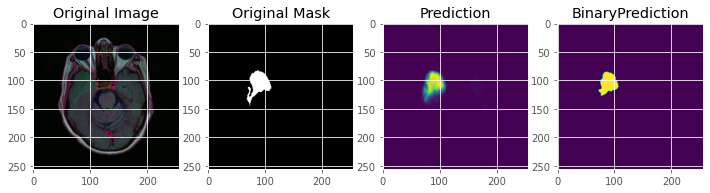

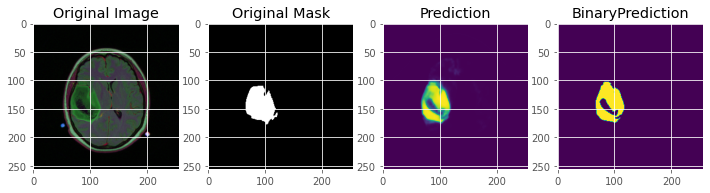

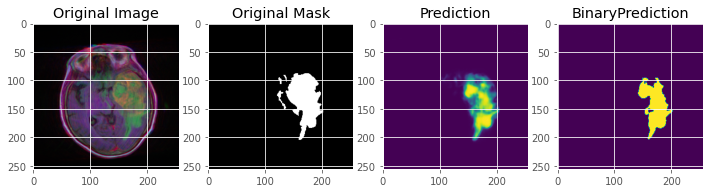

In [67]:
for i in range(10):
    idx = np.random.randint(0, len(imInfo_df))
    
    imagePath = os.path.join(DataPath, imInfo_df['directory'].iloc[idx], imInfo_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imInfo_df['directory'].iloc[idx], imInfo_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    img = cv2.resize(image ,(IMG_HIEGHT, IMG_WIDTH))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred = model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred))
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(pred) > 0.5)
    plt.title('BinaryPrediction')
    plt.show()

Из-за бинарного представления ответа пришлось добавить большое количество эпох, для укрепления связей. В целом, модель показывает точность в 99%, однако хотелось бы как-то посмотреть на сколько совпадают области оригинальной маски и область предсказанной маски.